# Comparative Analysis of Two HFM-Based Strategies in Rates Trading

Date: December 28 | Author: Kaichong Wang

In this study, we evaluated two simple and widely-used rate trading strategies: **PCA butterfly trading** and **cointegrated butterfly trading**. Both strategies use Historical Factor Model (HFM) and aim to identify mean-reverting stationary alpha factors and construct a replicating portfolio, typically a butterfly spreads. We tested the stationarity, stability, and predictability of these two models' alpha factor (butterfly spread rate) using empirical data from the past five years. Our study finds that the butterfly spreads on 3-Year, 5-Year, and 10-Year CMTs constructed based on the PCA model and CCA model show effectiveness under market conditions in 2023. The factors exhibit significant stationarity and mean-reversion against the unit root process and random walk process under a 95\% confidence level, and the dynamic mean-reversion signals on the butterfly are predictive with hit rates significantly above 50%. Additionally, the PC-Neutralized butterfly outperforms the cointegrated butterfly considerably.

---
## 1. Setups & Data Loading
---

In [71]:
import numpy as np
import pandas as pd
import quandl
import statsmodels.api as sm
from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller

from arch.unitroot import VarianceRatio

import warnings
warnings.filterwarnings('ignore')

In [72]:
ESTIMATION_START, TESTING_START = '2019-01-01', '2023-01-01'
LEFT_WING_MAT, BELLY_MAT, RIGHT_WING_MAT = '3 YR', '5 YR', '10 YR'

COLOR_1 = '#cd5b45'
PALETTE_1 = ['#a04b3b', '#cd5b45', '#d29185']

COLOR_2 = 'black'
PALETTE_2 = ['red', 'black', 'green']

COLOR_PCA = '#1560bd'
COLOR_COINT = '#ea9f42'

In [73]:
# Download the CMT rates
authToken = 'hm5ChpZuhG1Fq9d7pKiF'
df = quandl.get("USTREASURY/YIELD", authtoken = authToken)
df.index = pd.to_datetime(df.index)
df = df.drop(columns=['2 MO'])
df = df.loc[:'2023-12-28']
df

,1 MO,3 MO,6 MO,1 YR,2 YR,3 YR,5 YR,7 YR,10 YR,20 YR,30 YR
Date,,,,,,,,,,,
1990-01-02,NaN,7.83,7.89,7.81,7.87,7.90,7.87,7.98,7.94,NaN,8.00
1990-01-03,NaN,7.89,7.94,7.85,7.94,7.96,7.92,8.04,7.99,NaN,8.04
1990-01-04,NaN,7.84,7.90,7.82,7.92,7.93,7.91,8.02,7.98,NaN,8.04
1990-01-05,NaN,7.79,7.85,7.79,7.90,7.94,7.92,8.03,7.99,NaN,8.06
1990-01-08,NaN,7.79,7.88,7.81,7.90,7.95,7.92,8.05,8.02,NaN,8.09
...,...,...,...,...,...,...,...,...,...,...,...
2023-12-21,5.54,5.42,5.31,4.84,4.33,4.06,3.87,3.91,3.89,4.19,4.03
2023-12-22,5.54,5.44,5.31,4.82,4.31,4.04,3.87,3.92,3.90,4.21,4.05
2023-12-26,5.53,5.45,5.28,4.83,4.26,4.05,3.89,3.91,3.89,4.20,4.04


The Constant Maturity Treasury (CMT) rates are constructed using the following methodology:

Yields are interpolated by the Treasury from the daily par yield curve. This curve, which relates the yield on a security to its time to maturity, is based on the closing market bid prices on the most recently auctioned Treasury securities in the over-the-counter market. These par yields are derived from indicative, bid-side market price quotations (not actual transactions) obtained by the Federal Reserve Bank of New York at or near 3:30 PM each trading day. The CMT yield values are read from the par yield curve at fixed maturities, currently 1, 2, 3, 4 and 6 months and 1, 2, 3, 5, 7, 10, 20, and 30 years. This method provides a par yield for a 10-year maturity, for example, even if no outstanding security has exactly 10 years remaining to maturity.

The Treasury par yield curve (CMT rates) is estimated daily using a monotone convex spline method. Inputs to the model are indicative bid-side prices for the most recently auctioned nominal Treasury securities. Treasury reserves the option to make changes to the yield curve as appropriate and in its sole discretion.

In [74]:
df_estimation = df.loc[ESTIMATION_START:TESTING_START]
df_test = df.loc[TESTING_START:]

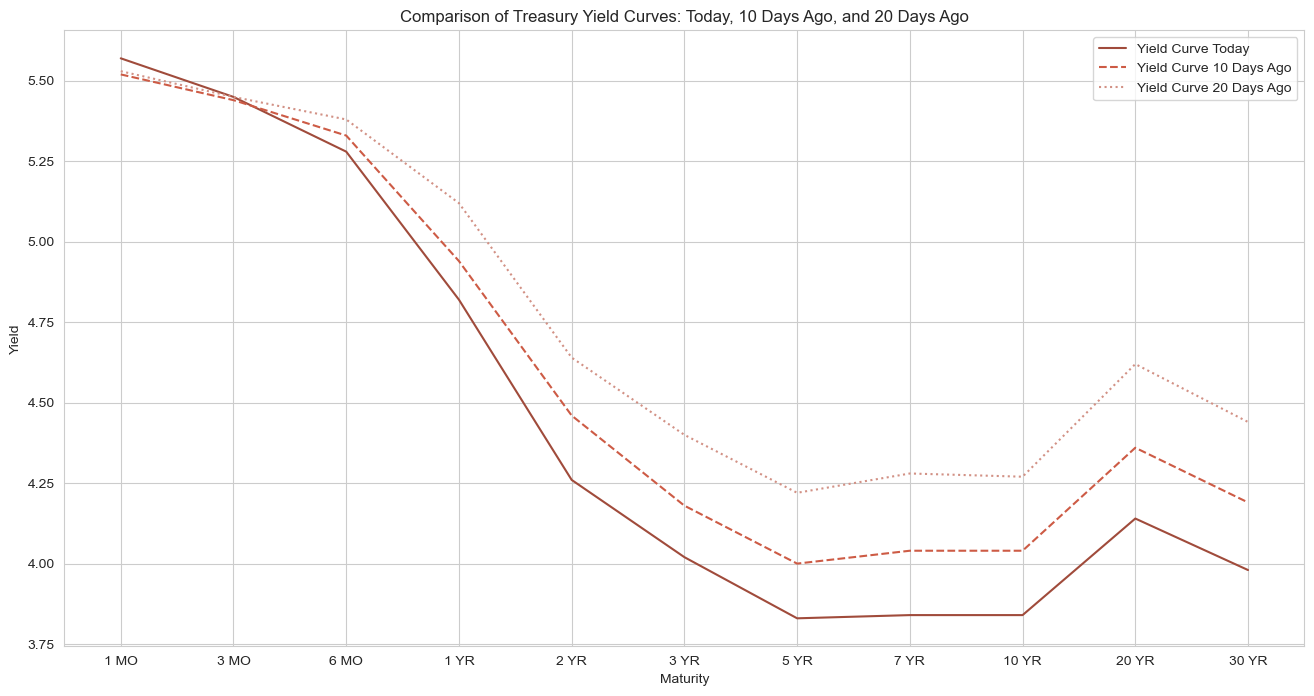

In [75]:
yields_today = df_test.iloc[-1]
yields_10_days_ago = df_test.iloc[-11]
yields_20_days_ago = df_test.iloc[-21]

sns.set_style("whitegrid")
plt.figure(figsize=(16, 8))
line_styles = ['-', '--', ':']

plt.plot(df_test.columns, yields_today, line_styles[0], color=PALETTE_1[0], label='Yield Curve Today')
plt.plot(df_test.columns, yields_10_days_ago, line_styles[1], color=PALETTE_1[1], label='Yield Curve 10 Days Ago')
plt.plot(df_test.columns, yields_20_days_ago, line_styles[2], color=PALETTE_1[2], label='Yield Curve 20 Days Ago')

plt.xlabel('Maturity')
plt.ylabel('Yield')
plt.title('Comparison of Treasury Yield Curves: Today, 10 Days Ago, and 20 Days Ago')

plt.legend()
plt.show()

Here are some implications from the shapes of the recent yield curves:

- **Normal to Flat/Inverted Transition**: Today's yield curve appears to be flat or slightly inverted, especially in the long-term maturities (10 to 30 years). This flattening or inversion where short-term yields are similar to or higher than long-term yields could be interpreted as a sign of uncertainty in the market about future economic growth, and expected slower growth or potentially recessionary conditions in the future.

- **Short-Term Yield Movements**: The short end of the curve (1 month to 2 years) has shown a noticeable increase in yields today compared to 10 and 20 days ago. This could suggest that the market anticipates a tighter monetary policy from the central bank, possibly in response to inflationary pressures or other economic factors, leading to higher short-term interest rates.

- **Mid to Long-Term Volatility**: There is volatility in the mid to long-term segment of the curve (2 to 30 years), with yields showing significant changes over the past 20 days. This could indicate changing expectations for long-term economic conditions, such as growth, inflation, and fiscal policy impacts.

---
## 2. Engineering the Two Factors
---

### 2.1. PCA Butterfly Trading

The first strategy is termed the *PCA Butterfly Trading*. In this approach, we perform principal component analysis (PCA) on the rate changes across different maturities during the estimation period. Our aim is to isolate the first two principal components that capture the majority of variance in maturity changes. Sub_tsequently, we construct a three-rate portfolio, commonly referred to as a butterfly (for instance, using 3-Year CMT, 5-Year CMT, and 10-Year CMT rates), designed to neutralize sensitivity to the initial principal components. To clarify, we compute the weights of the portfolio by solving the linear system such that the first-order derivatives with respect to both the first and second principal components equal zero—achieving what we define as PC neutrality.

The methodology we adopted, inspired by the Salomon Smith Barney report, integrates PCA into butterfly trading through a series of systematic steps. First, we compute rate changes at each time point over the estimation period, represented mathematically as $ \Delta \mathbf{y}_t = \mathbf{y}_{t+1} - \mathbf{y}_t $, where $ T \times n $ are the dimensions. Unlike some approaches that standardize data at this stage, our methodology bypasses this step. Following this, we construct the covariance matrix of the rate changes. We then perform eigenvalue decomposition on the covariance matrix:

$$ \text{Cov}(\Delta \mathbf{y}_t) = \mathbf{E} \cdot \mathbf{\Lambda} \cdot \mathbf{E}^{\intercal} $$

where $ \mathbf{E} $ represents the eigenvectors, $ \mathbf{E}^{(2)} $ represents the first two eigenvectors, which serve as the factor loadings in the model with dimensions $ n \times 2 $, and $ \mathbf{\Lambda} $ is the diagonal matrix of eigenvalues (for two PCs, its dimensions are $ 2 \times 2 $). The weights of our PC-Neutralized Butterfly are determined by solving the equation

\begin{align}
\mathbf{E}^{(2)}\cdot\mathbf{w}_\text{pca} &= \mathbf{0} \\
w_\text{pca}^{\text{belly}} &= -1
\end{align}

Here, $ w_{\text{pca}}^{\text{belly}} $ refers to the second element of $ \mathbf{w}_{\text{pca}} $, which corresponds to the "belly" position.

In [76]:
# Perform PCA on the dataset using `df_estimation`
df_estimation_chg = df_estimation.shift(-1) - df_estimation
df_estimation_chg = df_estimation_chg.dropna()
delta_y = df_estimation_chg.to_numpy()

# Step 1: Standardize the data
# mean_delta_y = np.mean(delta_y, axis=0)
# std_delta_y = np.std(delta_y, axis=0)
# standardized_delta_y = (delta_y - mean_delta_y) / std_delta_y

# Step 2: Calculate the covariance matrix
# cov_matrix = np.cov(standardized_delta_y, rowvar=False)
cov_matrix = np.cov(delta_y, rowvar=False)

# Step 3: Find eigenvalues (E) and eigenvectors (Lambda)
eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)

# Step 4: Sort eigenvalues and eigenvectors
sorted_indices = np.argsort(eigenvalues)[::-1]
eigenvalues = eigenvalues[sorted_indices]
eigenvectors = eigenvectors[:, sorted_indices]

# Step 5: Choose the top k (in our case, 2) eigenvectors
k = 2  # You can choose the number of principal components you want
top_eigenvectors = eigenvectors[:, :k]

# Step 6: Project the data onto the k-dimensional sub_tspace
# factor_representation = np.dot(standardized_delta_y, top_eigenvectors)
# factor_representation = np.dot(delta_y, top_eigenvectors)

# Step 7: Reconstruct the data using the k-factor model
# reconstructed_data = np.dot(factor_representation, top_eigenvectors.T)

# Step 8: Express the total change as a sum of the k-factor model and residual return
# residual_return = standardized_delta_y - reconstructed_data
# residual_return = delta_y - reconstructed_data

# 'factor_representation' contains the factors of the k-factor PCA model
# 'reconstructed_data' represents the data reconstructed using the k factors
# 'residual_return' holds the residual return not captured by the k-factor model

In [77]:
# Let's first table the factor loadings for each CMT
factor_loadings = pd.DataFrame(eigenvectors[:, :2].T, columns=df.columns, index=['PCA Factor 1', 'PCA Factor 2'])
factor_loadings

,1 MO,3 MO,6 MO,1 YR,2 YR,3 YR,5 YR,7 YR,10 YR,20 YR,30 YR
PCA Factor 1,-0.041752,-0.093664,-0.134062,-0.207382,-0.313085,-0.355104,-0.387168,-0.400886,-0.387770,-0.356188,-0.341378
PCA Factor 2,-0.260847,-0.369651,-0.371471,-0.408455,-0.320619,-0.226052,-0.047979,0.091355,0.209029,0.359160,0.391481


In [78]:
results = np.linalg.solve(factor_loadings[[LEFT_WING_MAT, RIGHT_WING_MAT]].to_numpy(), factor_loadings[[BELLY_MAT]].to_numpy())
weights_PCA = np.array([results[0, 0], -1.0, results[1, 0]])

# Display the results
print("Weights in PC-Neutralized Butterfly")
print("-" * 37)
print(f"Weight of {LEFT_WING_MAT}: {weights_PCA[0]:.4f}")
print(f"Weight of {BELLY_MAT}: -1")
print(f"Weight of {RIGHT_WING_MAT}: {weights_PCA[2]:.4f}")

Weights in PC-Neutralized Butterfly
-------------------------------------
Weight of 3 YR: 0.6149
Weight of 5 YR: -1
Weight of 10 YR: 0.4354


### 2.2. Conintegration Butterfly Trading

The second strategy is known as *Cointegration Buterfly Trading*. This method involves conducting cointegration analysis on the time series of rates for three distinct maturities during the estimation period, such as the 3-Year, 5-Year, and 10-Year Constant Maturity Treasury (CMT) rates. The goal is to derive a linear combination of these three inherently non-stationary time series that will exhibit the greatest degree of stationarity, as determined through cointegration analysis—here, we apply the Box-Tiao method. The stationary time series is then mirrored in a portfolio structured as a butterfly. Consequently, we calculate the respective weights for the portfolio to match this stationary combination. 

In our cointegration butterfly trading strategy, we adopt the simplest Box-Tiao procedure, following d'Aspremont's work. This approach focuses on replicating a stationary factor using a butterfly spread. The core of this methodology is encapsulated in a series of equations that describe the time series dynamics. We define our time series (the panel data of $ m $ rates) as $ \mathbf{y}^{(m)}_{t} $, with $ \mathbf{A} $ as the evolution matrix, $ \hat{\mathbf{A}} $ as the estimated evolution matrix, and $ \mathbf{\epsilon}_t $ representing noise. The dynamics are governed by the state evolution equation.

$$ \mathbf{y}^{(m)}t = \mathbf{y}^{(m)}{t-1} \mathbf{A} + \mathbf{\epsilon}_t $$

The evolution matrix can be estimated using the OLS estimator, specifically,

\begin{align}
    \hat{\mathbf{y}}^{(m)}_t &= \mathbf{y}^{(m)}_{t-1} \cdot \hat{\mathbf{A}} \\
    \hat{\mathbf{A}} &= ({\mathbf{y}^{(m)}_{t-1}}^{\intercal} {\mathbf{y}^{(m)}_{t-1})}^{-1} {\mathbf{y}^{(m)}_{t-1}}^{\intercal} \mathbf{y}^{(m)}_{t}
\end{align}

Assuming the positiveness of $ {\mathbf{y}^{(m)}}_t^\intercal \mathbf{y}^{(m)}_t $ and $ \mathbf{A} \approx \hat{\mathbf{A}} $, the predictability ratio matrix $ \mathbf{Q} $ is computed as follows:

$$ \mathbf{Q} = \mathbf{\Sigma}^{-1} \hat{\mathbf{A}}^\intercal \mathbf{\Sigma} \hat{\mathbf{A}} $$

where $ \mathbf{\Sigma} = \text{Cov}(\mathbf{y}^{(m)}_t) $. The eigenvalues and eigenvectors decomposed from the predictability ratio matrix are crucial. The smallest eigenvalue indicates the most mean-reverting direction, while the largest eigenvalue suggests the least mean-reverting direction. The weight vector of the cointegrated butterfly is proportional to the eigenvector corresponding to the smallest eigenvalue.

$$ \mathbf{w}_\text{coint} = - \frac{\mathbf{v}_1}{w_{\text{coint}}^{\text{belly}}} $$

Here, $ \mathbf{v}1 $ represents the eigenvector of $ \mathbf{Q} $ associated with the smallest eigenvalue, and $ w_{\text{coint}}^{\text{belly}} $ refers to the second element of $ \mathbf{v}_1 $, which corresponds to the "belly" position.


In [79]:
def get_cb_weights(left_wing, belly, right_wing):
    left_wing_demeaned = (left_wing - left_wing.mean())[1:].to_numpy()
    belly_demeaned = (belly - belly.mean())[1:].to_numpy()
    right_wing_demeaned = (right_wing - right_wing.mean())[1:].to_numpy()

    left_wing_demeaned_lag = (left_wing - left_wing.mean()).shift().dropna().to_numpy()
    belly_demeaned_lag = (belly - belly.mean()).shift().dropna().to_numpy()
    right_wing_demeaned_lag = (right_wing - right_wing.mean()).shift().dropna().to_numpy()

    Y_t = np.array([left_wing_demeaned, belly_demeaned, right_wing_demeaned]).T
    Y_t_lag = np.array([left_wing_demeaned_lag, belly_demeaned_lag, right_wing_demeaned_lag]).T

    A_hat = np.linalg.inv(Y_t_lag.T @ Y_t_lag) @ Y_t_lag.T @ Y_t
    Sigma = np.cov(Y_t, rowvar=False)
    Q = np.linalg.inv(Sigma) @ A_hat.T @ Sigma @ A_hat
    val, vec = np.linalg.eig(Q)
    weights = - vec[:, np.argmin(val)] / vec[:, np.argmin(val)][1]
    
    return weights

weights_coint = get_cb_weights(df_estimation[LEFT_WING_MAT], df_estimation[BELLY_MAT], df_estimation[RIGHT_WING_MAT])

# Display the results
print("Weights in Cointegrated Butterfly")
print("-" * 37)
print(f"Weight of {LEFT_WING_MAT}: {weights_coint[0]:.4f}")
print(f"Weight of {BELLY_MAT}: -1")
print(f"Weight of {RIGHT_WING_MAT}: {weights_coint[2]:.4f}")

Weights in Cointegrated Butterfly
-------------------------------------
Weight of 3 YR: 0.5142
Weight of 5 YR: -1
Weight of 10 YR: 0.5184


---
## 3. Comparative Analysis and Evaluation
---

### 3.1. Visualization and Descriptive Statistics

In [80]:
df_factors = df.loc[ESTIMATION_START:][[LEFT_WING_MAT, BELLY_MAT, RIGHT_WING_MAT]].copy()
df_factors['PC-Neutralized Butterfly'] = df_factors[[LEFT_WING_MAT, BELLY_MAT, RIGHT_WING_MAT]].values @ weights_PCA
df_factors['Cointegrated Butterfly'] = df_factors[[LEFT_WING_MAT, BELLY_MAT, RIGHT_WING_MAT]].values @ weights_coint
df_factors

,3 YR,5 YR,10 YR,PC-Neutralized Butterfly,Cointegrated Butterfly
Date,,,,,
2019-01-02,2.47,2.49,2.66,0.186824,0.159047
2019-01-03,2.35,2.37,2.56,0.189503,0.165501
2019-01-04,2.47,2.49,2.67,0.191178,0.164231
2019-01-07,2.51,2.53,2.70,0.188834,0.160352
2019-01-08,2.57,2.58,2.73,0.188786,0.156758
...,...,...,...,...,...
2023-12-21,4.06,3.87,3.89,0.319969,0.234291
2023-12-22,4.04,3.87,3.90,0.312026,0.229190
2023-12-26,4.05,3.89,3.89,0.293821,0.209149


In [81]:
df_factors[['PC-Neutralized Butterfly', 'Cointegrated Butterfly']].loc[:TESTING_START].describe()

,PC-Neutralized Butterfly,Cointegrated Butterfly
count,1001.000000,1001.000000
mean,0.124200,0.130826
std,0.072932,0.052378
min,-0.044005,-0.000769
25%,0.078235,0.104395
50%,0.124442,0.137468
75%,0.166352,0.169276
max,0.353707,0.244566


In [82]:
df_factors[['PC-Neutralized Butterfly', 'Cointegrated Butterfly']].loc[TESTING_START:].describe()

,PC-Neutralized Butterfly,Cointegrated Butterfly
count,249.000000,249.000000
mean,0.309928,0.205658
std,0.022523,0.026900
min,0.251263,0.136062
25%,0.294333,0.184812
50%,0.310498,0.206769
75%,0.325333,0.226883
max,0.360281,0.268682


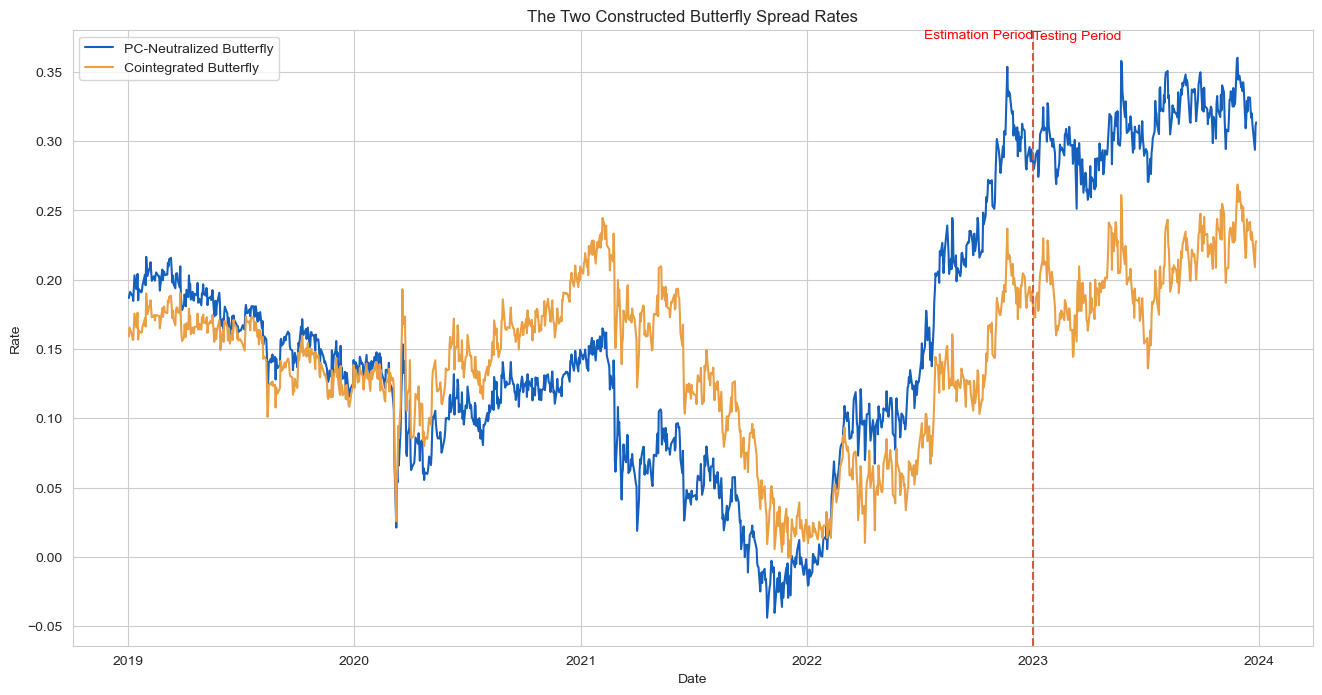

In [83]:
sns.set_style("whitegrid")
plt.figure(figsize=(16, 8))

plt.plot(df_factors.index, df_factors[['PC-Neutralized Butterfly']], '-', color=COLOR_PCA, label='PC-Neutralized Butterfly')
plt.plot(df_factors.index, df_factors[['Cointegrated Butterfly']], '-', color=COLOR_COINT, label='Cointegrated Butterfly')

plt.xlabel('Date')
plt.ylabel('Rate')
plt.title('The Two Constructed Butterfly Spread Rates')

testing_date = datetime.strptime(TESTING_START, '%Y-%m-%d')
plt.axvline(x=testing_date, color='#cd5b45', linestyle='--')
plt.text(testing_date, plt.ylim()[1], 'Estimation Period', color='red', horizontalalignment='right', verticalalignment='top')
plt.text(testing_date, plt.ylim()[1], 'Testing Period', color='red', horizontalalignment='left', verticalalignment='top')

plt.legend()
plt.show()

**Observation**
- Upon visual examination of the plotted data, the cointegrated butterfly displays a lower tendency towards trending behavior within the in-sample period when compared to the PC-neutralized butterfly. The conintegrated factor maintains a more consistent mean, suggestive of stronger mean-reverting characteristics. 
- In the out-of-sample period, this mean-reversion of PC-neutralized butterfly becomes more significant, particularly noticeable from late 2023 onwards where the cointegrated butterfly's mean exhibits an upward trajectory. 

In [84]:
factor_dict = {'PC-Neutralized Butterfly, In-sample': df_factors.loc[:TESTING_START]['PC-Neutralized Butterfly'],
               'PC-Neutralized Butterfly, Out-sample': df_factors.loc[TESTING_START:]['PC-Neutralized Butterfly'],
               'Cointegrated Butterfly, In-sample': df_factors.loc[:TESTING_START]['Cointegrated Butterfly'],
               'Cointegrated Butterfly, Out-sample': df_factors.loc[TESTING_START:]['Cointegrated Butterfly']
               }

### 3.2. Assessing Factor Stationarity: ADF Test

**ADF Test**

The Augmented Dickey-Fuller (ADF) test is used to determine whether a time series is stationary. A time series is considered stationary if its properties do not depend on the time at which the series is observed. A more negative ADF statistic and a smaller p-value suggest a higher level of significance for stationarity (stronger rejection of the null hypothesis that there is a unit root).

In [85]:
def calculate_adf_stat(series):
    adf_statistic, p_value, _, _, _, _ = adfuller(series)
    return adf_statistic, p_value

print('Accessing Factor Stationarity: ADF Statistics')
print('-'*90)
for factor_name, factor_ts in factor_dict.items():
    adf_stat, p_value = calculate_adf_stat(factor_ts)
    print(f"{factor_name}: \t ADF Statistic: {adf_stat:.4f}, \t p-value: {p_value:.4f}")

Accessing Factor Stationarity: ADF Statistics
------------------------------------------------------------------------------------------
PC-Neutralized Butterfly, In-sample: 	 ADF Statistic: -0.6081, 	 p-value: 0.8691
PC-Neutralized Butterfly, Out-sample: 	 ADF Statistic: -3.1216, 	 p-value: 0.0250
Cointegrated Butterfly, In-sample: 	 ADF Statistic: -1.5025, 	 p-value: 0.5323
Cointegrated Butterfly, Out-sample: 	 ADF Statistic: -2.8778, 	 p-value: 0.0480


The PC-Neutralized Butterfly exhibits better out-of-sample stationarity compared to the Cointegrated Butterfly.

### 3.3. Assessing Factor Mean-Reversion / Stability: Variance Ratio Test

**Variance Ratio Test**

This Variance Ratio Test is used to analyze the mean-reversiveness of a time series as opposed to a random walk, a state where the series' increments are uncorrelated over time. The test calculates the Variance Ratio at lag $ k $ using the formula 
$$ VR(k) = \frac{\text{Var}(f_t - f_{t-k})}{k \cdot \text{Var}(f_t - f_{t-1})} $$
where $ \text{Var}(f_t - f_{t-k}) $ is the variance of $ k $-period returns, and $ \text{Var}(f_t - f_{t-1}) $ is the variance of one-period returns. A $ VR(k) $ close to 1 suggests a random walk. Values significantly less than 1 indicate mean reversion, suggesting that the series is mean-reversive. A lower VR statistic and a smaller p-value suggest stronger evidence against the random walk hypothesis. This supports a stronger mean-reversion tendency, indicating stability in the sense that the factor is less likely to deviate significantly from its historical mean for extended periods of time.

In [86]:
def calculate_vr_stat(series, lag=2):
    vr = VarianceRatio(series, lags=lag)
    return vr.stat, vr.pvalue

print('Accessing Factor Stability: Variance Ratio Test')
print('-'*90)
for factor_name, factor_ts in factor_dict.items():
    vr_stat, vr_pvalue = calculate_vr_stat(factor_ts)
    print(f"{factor_name}: \t VR Statistic: {vr_stat:.4f}, \t p-value: {vr_pvalue:.4f}")

Accessing Factor Stability: Variance Ratio Test
------------------------------------------------------------------------------------------
PC-Neutralized Butterfly, In-sample: 	 VR Statistic: -4.7203, 	 p-value: 0.0000
PC-Neutralized Butterfly, Out-sample: 	 VR Statistic: -3.4069, 	 p-value: 0.0007
Cointegrated Butterfly, In-sample: 	 VR Statistic: -3.8010, 	 p-value: 0.0001
Cointegrated Butterfly, Out-sample: 	 VR Statistic: -3.3182, 	 p-value: 0.0009


The PC-Neutralized Butterfly exhibits better out-of-sample mean-reversion / stability compared to the Cointegrated Butterfly.

### 3.4. Assessing Factor Predictability: Hit Rate

Ideally, our butterflies should follow the following dynamic:

$$
f_t = \mu_t + \epsilon_t
$$

where $\epsilon_t$ represents a mean-reverting process (often considered as a signal), defined by

$$
d\epsilon_t = -\theta\epsilon_t + \sigma_t dW_t
$$

If $\mu_t$ and $\sigma_t$ are time-invariant, the signal is not only mean-reverting but also stationary.

The fator is thus predictable. To evaluate the predictability of the factor, we apply a mean-reversion strategy test on the butterfly portfolios. This strategy involves setting a threshold based on the factor levels at time $t$, defined by the range
$$
\begin{cases}
\left[\hat{\mu}- z\cdot\hat{\sigma}, \hat{\mu}+ z\cdot\hat{\sigma}\right]&\text{in static model} \\
\left[\hat{\mu}_t- z\cdot\hat{\sigma}_t, \hat{\mu}_t+ z\cdot\hat{\sigma}_t\right]&\text{in dynamic model}
\end{cases}
$$ 
where $\hat{\mu}$ / $\hat{\mu}_t$ is the estimated mean and $\hat{\sigma}$ / $\hat{\sigma}_t$ is the estimated volatility of the factor (at time $t$), and $z$ is a predetermined z-score that determines the width of the threshold band. The signal time series is defined as:
$$
\begin{cases}
z_t = \frac{\left(f_t - \hat{\mu}\right)}{\hat{\sigma}} & \text{in the static model}, \\
z_t = \frac{\left(f_t - \hat{\mu_t}\right)}{\hat{\sigma_t}} & \text{in the dynamic model},
\end{cases}
$$

The strategy posits that if the factor value exceeds this threshold, it will revert to the range $[\hat{\mu} \pm z \cdot \hat{\sigma}]$ / $[\hat{\mu}_t \pm z \cdot \hat{\sigma}_t]$ within $ u $ days. We define the strategy's \textit{Hit Rate} as the frequency with which the factor value, upon crossing the specified threshold, reverts to its range which it diverged from. Signals are recognized cumulatively and are overlapping; that is, each instance where the factor strays from the threshold is noted and judged as a hit or miss, even if the factor has not yet returned within the set bounds. This approach ensures all divergences are accounted for in the analysis. Essentially, a *Hit Rate* exceeding 50% suggests reliable factor predictability. Conversely, a *Hit Rate* below 50% implies the strategy's ineffectiveness in capitalizing on mean-reversion tendencies.


#### 3.4.1. Static Model

In the static model, the estimated mean $ \hat{\mu} $ and volatility $ \hat{\sigma} $ are treated as constants throughout the testing period. These estimates are derived from the historical mean and volatility, calculated over a look-back period of $ k $ days.

The hyperparameters for this model are configured as follows:
- $ z = 1 $: This sets the confidence level at approximately 68%. A higher $z$ reflects a more conservative approach to the prediction interval.
- $ u = 5 $: This represents an expected market correction period of 5 days, within which the mean reversion is anticipated to occur.
- $ k = 30 $: Based on the premise that financial market information typically becomes obsolete after about 30 periods.

These hyperparameters are selected based on intuitive insights and conventional rules of thumb in financial market analysis. While they are arbitrary, they align with common practices and heuristic approaches in market modeling.

In [87]:
Z = 1
U = 5
K = 30

In [88]:
df_factors

,3 YR,5 YR,10 YR,PC-Neutralized Butterfly,Cointegrated Butterfly
Date,,,,,
2019-01-02,2.47,2.49,2.66,0.186824,0.159047
2019-01-03,2.35,2.37,2.56,0.189503,0.165501
2019-01-04,2.47,2.49,2.67,0.191178,0.164231
2019-01-07,2.51,2.53,2.70,0.188834,0.160352
2019-01-08,2.57,2.58,2.73,0.188786,0.156758
...,...,...,...,...,...
2023-12-21,4.06,3.87,3.89,0.319969,0.234291
2023-12-22,4.04,3.87,3.90,0.312026,0.229190
2023-12-26,4.05,3.89,3.89,0.293821,0.209149


In [89]:
# def calculate_hit_rate_static(df_factors, factor_name, overlaping=True):       
#     # Step 1. Estimate mean and volatility
#     mu_hat = df_factors[factor_name].loc[:TESTING_START].iloc[-K:].mean()
#     sigma_hat = df_factors[factor_name].loc[:TESTING_START].iloc[-K:].std()
#     lower_bound, upper_bound = mu_hat - Z * sigma_hat, mu_hat + Z * sigma_hat

#     # Step 2: Backtest
#     signal_flag = False
#     num_hit, num_miss = 0, 0
#     factor_ts_test = df_factors[factor_name].loc[TESTING_START:]
#     test_length = len(factor_ts_test)
#     hit_t = np.zeros(test_length)

#     for t in range(test_length):
#         factor_t = factor_ts_test.iloc[t]
#         end_index = min(t + U, test_length) # Ensure we don't go beyond the series length
        
#         if not signal_flag or overlaping:
#             if (factor_t < lower_bound):
#                 signal_flag = True
#                 # Check if any value in the next U days is greater than lower_bound
#                 if any(factor_ts_test.iloc[t+1:end_index] > lower_bound):
#                     num_hit += 1
#                     hit_t[t] = 1
#                 else:
#                     num_miss += 1
#                     hit_t[t] = -1

#             elif (factor_t > upper_bound):
#                 signal_flag = True
#                 # Check if any value in the next U days is smaller than upper_bound
#                 if any(factor_ts_test.iloc[t+1:end_index] < upper_bound):
#                     num_hit += 1
#                     hit_t[t] = 1
#                 else:
#                     num_miss += 1
#                     hit_t[t] = -1
                
#         else:
#             signal_flag = (factor_t < lower_bound) or (factor_t > upper_bound)
                

#     hit_rate = num_hit / (num_hit + num_miss) if (num_hit + num_miss) > 0 else None
#     z_t = (factor_ts_test - mu_hat) / sigma_hat
#     return mu_hat, lower_bound, upper_bound, num_hit, num_miss, hit_rate, hit_t, z_t

def calculate_hit_rate_static(df_factors, factor_name):       
    # Step 1. Estimate mean and volatility
    mu_hat = df_factors[factor_name].loc[:TESTING_START].iloc[-K:].mean()
    sigma_hat = df_factors[factor_name].loc[:TESTING_START].iloc[-K:].std()
    lower_bound, upper_bound = mu_hat - Z * sigma_hat, mu_hat + Z * sigma_hat

    # Step 2: Backtest
    num_hit, num_miss = 0, 0
    factor_ts_test = df_factors[factor_name].loc[TESTING_START:]
    test_length = len(factor_ts_test)
    hit_t = np.zeros(test_length)

    for t in range(test_length):
        factor_t = factor_ts_test.iloc[t]
        end_index = min(t + U, test_length) # Ensure we don't go beyond the series length
        
        if factor_t < lower_bound:
            # Check if any value in the next U days is greater than lower_bound
            if any(factor_ts_test.iloc[t+1:end_index] > lower_bound):
                num_hit += 1
                hit_t[t] = 1
            else:
                num_miss += 1
                hit_t[t] = -1

        elif factor_t > upper_bound:
            # Check if any value in the next U days is smaller than upper_bound
            if any(factor_ts_test.iloc[t+1:end_index] < upper_bound):
                num_hit += 1
                hit_t[t] = 1
            else:
                num_miss += 1
                hit_t[t] = -1

    hit_rate = num_hit / (num_hit + num_miss) if (num_hit + num_miss) > 0 else None
    z_t = (factor_ts_test - mu_hat) / sigma_hat
    return mu_hat, lower_bound, upper_bound, num_hit, num_miss, hit_rate, hit_t, z_t
    

mu_PCA, lower_bound_PCA, upper_bound_PCA, num_hit_PCA, num_miss_PCA, hit_rate_PCA, hit_PCA, z_PCA = calculate_hit_rate_static(df_factors, 'PC-Neutralized Butterfly')
mu_coint, lower_bound_coint, upper_bound_coint, num_hit_coint, num_miss_coint, hit_rate_coint, hit_coint, z_coint = calculate_hit_rate_static(df_factors, 'Cointegrated Butterfly')

print('Assessing Factor Predictability: Hit Rate (Static Model)')
print('-'*80)
print(f"PC-Neutralized Butterfly: \t#Hit: {num_hit_PCA:.0f}, \t#Miss: {num_miss_PCA:.0f}, \tHit Rate: {hit_rate_PCA:.4f}")
print(f"Cointegrated Butterfly: \t#Hit: {num_hit_coint:.0f}, \t#Miss: {num_miss_coint:.0f}, \tHit Rate: {hit_rate_coint:.4f}")

Assessing Factor Predictability: Hit Rate (Static Model)
--------------------------------------------------------------------------------
PC-Neutralized Butterfly: 	#Hit: 70, 	#Miss: 43, 	Hit Rate: 0.6195
Cointegrated Butterfly: 	#Hit: 83, 	#Miss: 79, 	Hit Rate: 0.5123


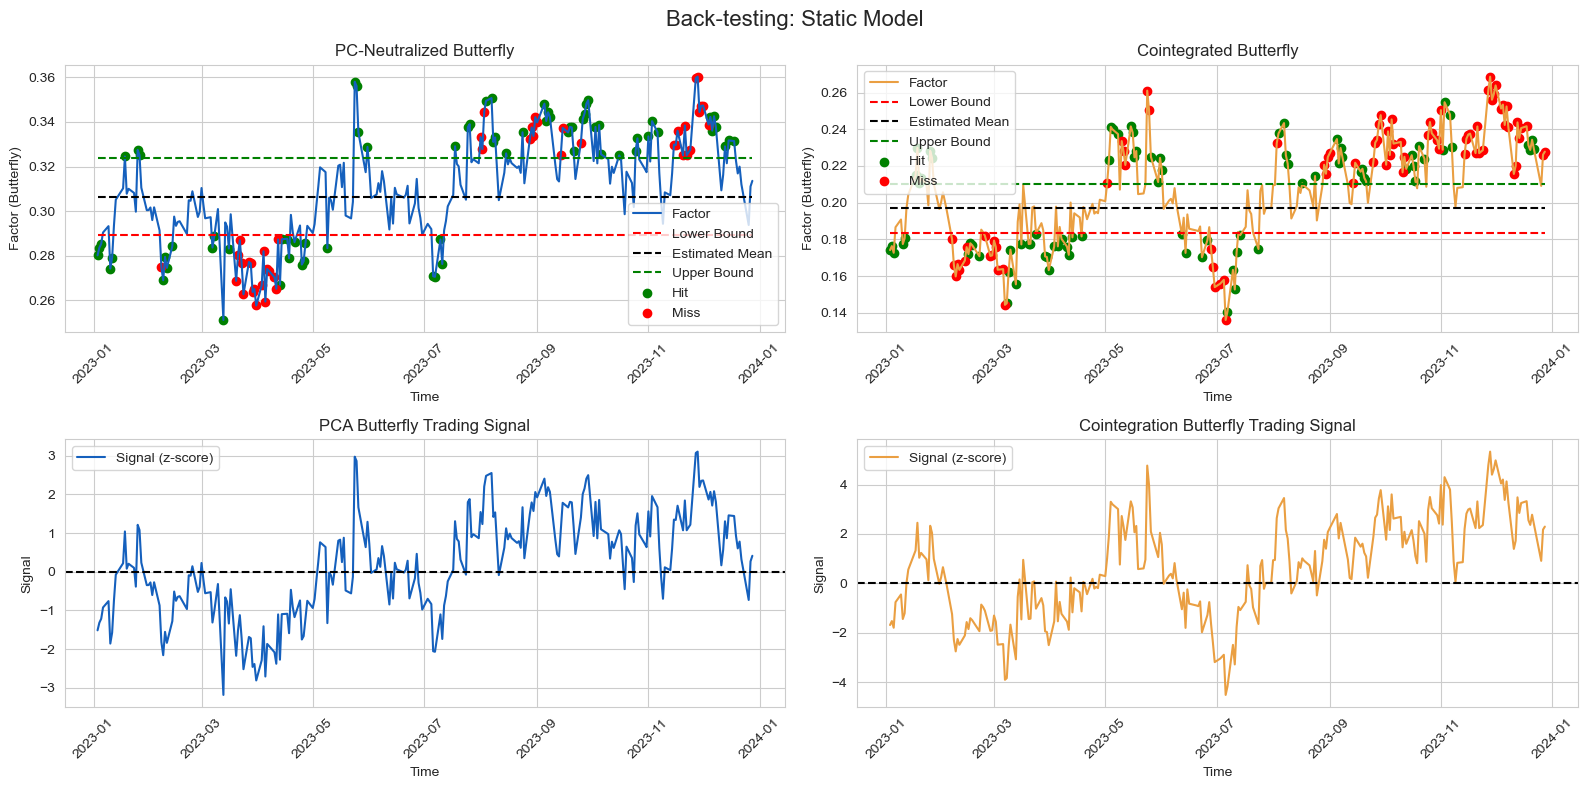

In [90]:
df_PCA = df_factors['PC-Neutralized Butterfly'].loc[TESTING_START:].copy().to_frame()
df_PCA['Mean'] = mu_PCA
df_PCA['Lower Bound'] = lower_bound_PCA
df_PCA['Upper Bound'] = upper_bound_PCA
df_PCA = df_PCA.rename(columns={'PC-Neutralized Butterfly':'Factor'})
df_PCA['Hit/Miss'] = hit_PCA
df_PCA['Signal'] = z_PCA

df_coint = df_factors['Cointegrated Butterfly'].loc[TESTING_START:].copy().to_frame()
df_coint['Mean'] = mu_coint
df_coint['Lower Bound'] = lower_bound_coint
df_coint['Upper Bound'] = upper_bound_coint
df_coint['Hit/Miss'] = hit_coint
df_coint['Signal'] = z_coint
df_coint = df_coint.rename(columns={'Cointegrated Butterfly':'Factor'})


# Plot the figures
plt.figure(figsize=(16, 8))

plt.subplot(2, 2, 1)
plt.plot(df_PCA.index, df_PCA['Factor'], label='Factor', color=COLOR_PCA, linestyle='-')
plt.plot(df_PCA.index, df_PCA['Lower Bound'], label='Lower Bound', color=PALETTE_2[0], linestyle='--')
plt.plot(df_PCA.index, df_PCA['Mean'], label='Estimated Mean', color=PALETTE_2[1], linestyle='--')
plt.plot(df_PCA.index, df_PCA['Upper Bound'], label='Upper Bound', color=PALETTE_2[2], linestyle='--')
plt.scatter(df_PCA[df_PCA['Hit/Miss'] == 1].index, df_PCA[df_PCA['Hit/Miss'] == 1]['Factor'], color=PALETTE_2[2], label='Hit')
plt.scatter(df_PCA[df_PCA['Hit/Miss'] == -1].index, df_PCA[df_PCA['Hit/Miss'] == -1]['Factor'], color=PALETTE_2[0], label='Miss')
plt.title('PC-Neutralized Butterfly')
plt.xlabel('Time')
plt.ylabel('Factor (Butterfly)')
plt.legend(loc='best')
plt.xticks(rotation=45)

plt.subplot(2, 2, 2)
plt.plot(df_coint.index, df_coint['Factor'], label='Factor', color=COLOR_COINT, linestyle='-')
plt.plot(df_coint.index, df_coint['Lower Bound'], label='Lower Bound', color=PALETTE_2[0], linestyle='--')
plt.plot(df_coint.index, df_coint['Mean'], label='Estimated Mean', color=PALETTE_2[1], linestyle='--')
plt.plot(df_coint.index, df_coint['Upper Bound'], label='Upper Bound', color=PALETTE_2[2], linestyle='--')
plt.scatter(df_coint[df_coint['Hit/Miss'] == 1].index, df_coint[df_coint['Hit/Miss'] == 1]['Factor'], color=PALETTE_2[2], label='Hit')
plt.scatter(df_coint[df_coint['Hit/Miss'] == -1].index, df_coint[df_coint['Hit/Miss'] == -1]['Factor'], color=PALETTE_2[0], label='Miss')
plt.title('Cointegrated Butterfly')
plt.xlabel('Time')
plt.ylabel('Factor (Butterfly)')
plt.legend(loc='best')
plt.xticks(rotation=45)

plt.subplot(2, 2, 3)
plt.plot(df_PCA.index, df_PCA['Signal'], label='Signal (z-score)', color=COLOR_PCA, linestyle='-')
plt.axhline(y=0, color=PALETTE_2[1], linestyle='--')
plt.title('PCA Butterfly Trading Signal')
plt.xlabel('Time')
plt.ylabel('Signal')
plt.legend(loc='best')
plt.xticks(rotation=45)

plt.subplot(2, 2, 4)
plt.plot(df_coint.index, df_coint['Signal'], label='Signal (z-score)', color=COLOR_COINT, linestyle='-')
plt.axhline(y=0, color=PALETTE_2[1], linestyle='--')
plt.title('Cointegration Butterfly Trading Signal')
plt.xlabel('Time')
plt.ylabel('Signal')
plt.legend(loc='best')
plt.xticks(rotation=45)

plt.suptitle('Back-testing: Static Model', fontsize=16)
plt.subplots_adjust(top=0.92)
plt.tight_layout()
plt.show()

#### 3.4.2. Dynamic Model

In the dynamic model, the estimated mean $ \hat{\mu}_t $ and volatility $ \hat{\sigma}_t $ are dynamic throughout the testing period. These estimates are derived using an exponential weighted moving average (EWMA), with the initial values for $ \hat{\mu}_t $ and $ \hat{\sigma}_t $ set to the historical mean and volatility calculated over a look-back period of $ k $ days. The update formulas for the dynamic model are as follows:

$$
\begin{align*}
\hat{\mu}_t &= \lambda_\mu f_t + (1 - \lambda_\mu) \hat{\mu}_{t-1} \\
\hat{\sigma}_t &= \sqrt{\lambda_\sigma \left(f_t - \hat{\mu}_{t-1}\right)^2 + (1 - \lambda_\sigma) \hat{\sigma}^2_{t-1}}
\end{align*}
$$

The hyperparameters for this model are configured as follows:
- $ z = 0.5 $: Given that the dynamic model greatly rises the conservativeness of the strategy, we need to lower the z-score for comparable trading frequency.
- $ u = 5 $: This denotes an expected market correction period of 5 days, during which mean reversion is anticipated.
- $ \lambda_\mu = 0.2 $ and $ \lambda_\sigma = 0.05 $: These values are chosen arbitrarily, with $ \lambda_\mu $ influencing the responsiveness of the mean estimate and $ \lambda_\sigma $ affecting the volatility estimate.
- $ k = 30 $: This reflects the assumption that financial market information generally becomes less relevant after approximately 30 timesteps.

While these hyperparameters are selected based on intuitive understanding and common heuristics in financial analysis, they are aligned with standard practices in dynamic market modeling.


In [91]:
Z = 0.5
LBD_MU = 0.2
LBD_SIGMA = 0.05

In [92]:
def calculate_hit_rate_dynamic(df_factors, factor_name):
    # Initilize mean and volatility
    mu_hat_0 = df_factors[factor_name].loc[:TESTING_START].iloc[-K:].mean()
    sigma_hat_0 = df_factors[factor_name].loc[:TESTING_START].iloc[-K:].std()

    num_hit, num_miss = 0, 0
    factor_ts_test = df_factors[factor_name].loc[TESTING_START:]
    test_length = len(factor_ts_test)
    mu_hat = np.zeros(test_length)
    sigma_hat = np.zeros(test_length)
    mu_hat[0] = mu_hat_0
    sigma_hat[0] = sigma_hat_0
    hit_t = np.zeros(test_length)

    # Backtesting loop
    for t in range(test_length):
        factor_t = factor_ts_test.iloc[t]

        # Estimate dynamic mean and volatility
        if t > 0:
            mu_hat[t] = LBD_MU * factor_t + (1 - LBD_MU) * mu_hat[t - 1]
            sigma_hat[t] = ((LBD_SIGMA * (factor_t - mu_hat[t - 1])**2) +
                            ((1 - LBD_SIGMA) * sigma_hat[t - 1]**2))**0.5

        # Determine bounds for current timestep
        lb_t, ub_t = mu_hat[t] - Z * sigma_hat[t], mu_hat[t] + Z * sigma_hat[t]

        # Check conditions for hitting the bounds
        if factor_t < lb_t:
            if any(factor_ts_test.iloc[t + 1:min(t + U, test_length)] > lb_t):
                num_hit += 1
                hit_t[t] = 1
            else:
                num_miss += 1
                hit_t[t] = -1
        elif factor_t > ub_t:
            if any(factor_ts_test.iloc[t + 1:min(t + U, test_length)] < ub_t):
                num_hit += 1
                hit_t[t] = 1
            else:
                num_miss += 1
                hit_t[t] = -1

    # Calculate hit rate
    hit_rate = num_hit / (num_hit + num_miss) if (num_hit + num_miss) > 0 else None
    z_t = (factor_ts_test - mu_hat) / sigma_hat
    
    return mu_hat, sigma_hat, num_hit, num_miss, hit_rate, hit_t, z_t


mu_PCA, sigma_PCA, num_hit_PCA, num_miss_PCA, hit_rate_PCA, hit_PCA, z_PCA = calculate_hit_rate_dynamic(df_factors, 'PC-Neutralized Butterfly')
mu_coint, sigma_coint, num_hit_coint, num_miss_coint, hit_rate_coint, hit_coint, z_coint = calculate_hit_rate_dynamic(df_factors, 'Cointegrated Butterfly')

print('Assessing Factor Predictability: Hit Rate (Dynamic Model)')
print('-'*80)
print(f"PC-Neutralized Butterfly: \t#Hit: {num_hit_PCA:.0f}, \t#Miss: {num_miss_PCA:.0f}, \tHit Rate: {hit_rate_PCA:.4f}")
print(f"Cointegrated Butterfly: \t#Hit: {num_hit_coint:.0f}, \t#Miss: {num_miss_coint:.0f}, \tHit Rate: {hit_rate_coint:.4f}")

Assessing Factor Predictability: Hit Rate (Dynamic Model)
--------------------------------------------------------------------------------
PC-Neutralized Butterfly: 	#Hit: 104, 	#Miss: 21, 	Hit Rate: 0.8320
Cointegrated Butterfly: 	#Hit: 104, 	#Miss: 32, 	Hit Rate: 0.7647


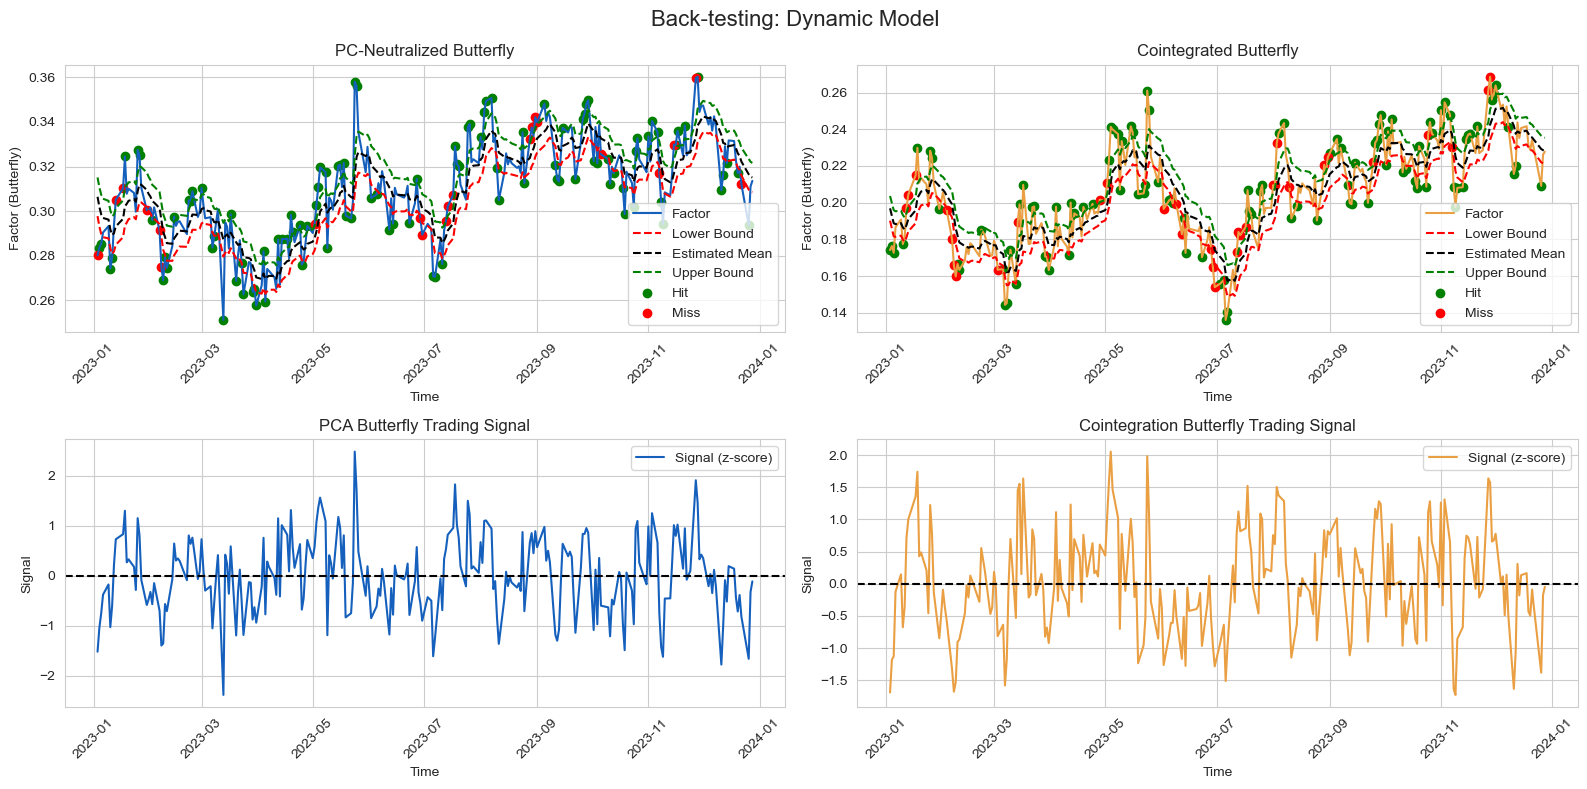

In [93]:
df_PCA = df_factors['PC-Neutralized Butterfly'].loc[TESTING_START:].copy().to_frame()
df_PCA['Mean'] = mu_PCA
df_PCA['Lower Bound'] = mu_PCA - Z * sigma_PCA
df_PCA['Upper Bound'] = mu_PCA + Z * sigma_PCA
df_PCA = df_PCA.rename(columns={'PC-Neutralized Butterfly':'Factor'})
df_PCA['Hit/Miss'] = hit_PCA
df_PCA['Signal'] = z_PCA

df_coint = df_factors['Cointegrated Butterfly'].loc[TESTING_START:].copy().to_frame()
df_coint['Mean'] = mu_coint
df_coint['Lower Bound'] = mu_coint - Z * sigma_coint
df_coint['Upper Bound'] = mu_coint + Z * sigma_coint
df_coint['Hit/Miss'] = hit_coint
df_coint['Signal'] = z_coint
df_coint = df_coint.rename(columns={'Cointegrated Butterfly':'Factor'})


# Plot the figures
plt.figure(figsize=(16, 8))

plt.subplot(2, 2, 1)
plt.plot(df_PCA.index, df_PCA['Factor'], label='Factor', color=COLOR_PCA, linestyle='-')
plt.plot(df_PCA.index, df_PCA['Lower Bound'], label='Lower Bound', color=PALETTE_2[0], linestyle='--')
plt.plot(df_PCA.index, df_PCA['Mean'], label='Estimated Mean', color=PALETTE_2[1], linestyle='--')
plt.plot(df_PCA.index, df_PCA['Upper Bound'], label='Upper Bound', color=PALETTE_2[2], linestyle='--')
plt.scatter(df_PCA[df_PCA['Hit/Miss'] == 1].index, df_PCA[df_PCA['Hit/Miss'] == 1]['Factor'], color=PALETTE_2[2], label='Hit')
plt.scatter(df_PCA[df_PCA['Hit/Miss'] == -1].index, df_PCA[df_PCA['Hit/Miss'] == -1]['Factor'], color=PALETTE_2[0], label='Miss')
plt.title('PC-Neutralized Butterfly')
plt.xlabel('Time')
plt.ylabel('Factor (Butterfly)')
plt.legend(loc='best')
plt.xticks(rotation=45)

plt.subplot(2, 2, 2)
plt.plot(df_coint.index, df_coint['Factor'], label='Factor', color=COLOR_COINT, linestyle='-')
plt.plot(df_coint.index, df_coint['Lower Bound'], label='Lower Bound', color=PALETTE_2[0], linestyle='--')
plt.plot(df_coint.index, df_coint['Mean'], label='Estimated Mean', color=PALETTE_2[1], linestyle='--')
plt.plot(df_coint.index, df_coint['Upper Bound'], label='Upper Bound', color=PALETTE_2[2], linestyle='--')
plt.scatter(df_coint[df_coint['Hit/Miss'] == 1].index, df_coint[df_coint['Hit/Miss'] == 1]['Factor'], color=PALETTE_2[2], label='Hit')
plt.scatter(df_coint[df_coint['Hit/Miss'] == -1].index, df_coint[df_coint['Hit/Miss'] == -1]['Factor'], color=PALETTE_2[0], label='Miss')
plt.title('Cointegrated Butterfly')
plt.xlabel('Time')
plt.ylabel('Factor (Butterfly)')
plt.legend(loc='best')
plt.xticks(rotation=45)

plt.subplot(2, 2, 3)
plt.plot(df_PCA.index, df_PCA['Signal'], label='Signal (z-score)', color=COLOR_PCA, linestyle='-')
plt.axhline(y=0, color=PALETTE_2[1], linestyle='--')
plt.title('PCA Butterfly Trading Signal')
plt.xlabel('Time')
plt.ylabel('Signal')
plt.legend(loc='best')
plt.xticks(rotation=45)

plt.subplot(2, 2, 4)
plt.plot(df_coint.index, df_coint['Signal'], label='Signal (z-score)', color=COLOR_COINT, linestyle='-')
plt.axhline(y=0, color=PALETTE_2[1], linestyle='--')
plt.title('Cointegration Butterfly Trading Signal')
plt.xlabel('Time')
plt.ylabel('Signal')
plt.legend(loc='best')
plt.xticks(rotation=45)

plt.suptitle('Back-testing: Dynamic Model', fontsize=16)
plt.subplots_adjust(top=0.92)
plt.tight_layout()
plt.show()

---
## 4. Limitations and Conclusion
---

This study demonstrates a methodology applicable to a trio of securities rate time series, yet it's crucial to note that the CMTs used are not directly tradable. Future work should adapt the derived butterfly spreads and signals for tradable securities. Moreover, the selection of hyperparameters was somewhat arbitrary; their sensitivity and impact on the model's performance require further analysis. Lastly, while the stationarity, stability, and predictability of the spreads have been tested, translating these factors into real-world effectiveness and profitability necessitates simulated trading and a thorough evaluation of the resulting profits and losses.

The study has successfully employed PCA and CCA models to construct butterfly spreads and assess their stationarity, stability, and predictability. Despite revealing that both strategies are stationary and stable, with the PCA model considerably outperforms, there remains a substantial leap from these theoretical constructs to actual trading viability. Future research should bridge this gap by applying the strategies to tradable instruments and rigorously testing their profitability through simulated trading environments.

---
## References
---

1. Baygün, B., Showers, J., & Cherpelis, G. (2000). Principles of Principal Components: A fresh look at Risk, Hedging, and Relative Value. Salomon Smith Barney.
2. Box, G. E., & Tiao, G. C. (1977). A canonical analysis of multiple time series. Biometrika, 64(2), 355-365.
3. Dai, Q., & Singleton, K. J. (2000). Specification analysis of affine term structure models. The Journal of Finance, 55(5), 1943-1978.
4. d'Aspremont, A. (2011). Identifying small mean-reverting portfolios. Quantitative Finance, 11(3), 351-364.
5. Engle, R. F., & Granger, C. W. J. (1987). Co-integration and error correction: representation, estimation, and testing. Econometrica: Journal of the Econometric Society, 251-276.
6. Fabozzi, F. J., & Mann, S. V. (2005). The Handbook of Fixed Income Securities. New York.
7. Eurex Frankfurt AG. (2007). Interest Rate Derivatives Fixed Income Trading Strategies. Frankfurt/Main, Bundesländer.
8. James, J., & Webber, N. (2000). Interest Rate Modelling. Wiley-Blackwell Publishing Ltd.
9. Johansen, S. (1988). Statistical analysis of cointegration vectors. Journal of Economic Dynamics and Control, 12(2-3), 231-254.
10. Knez, P. J., Litterman, R., & Scheinkman, J. (1994). Explorations into factors explaining money market returns. The Journal of Finance, 49(5), 1861-1882. Wiley Online Library.
11. Litterman, R. B., & Scheinkman, J. (1991). Common factors affecting bond returns. The Journal of Fixed Income, 1(1), 54-61.
12. Nasdaq Data Link. (n.d.). Treasury Yield Curve Rates. Retrieved December 14, 2023, from https://data.nasdaq.com/data/USTREASURY/YIELD-treasury-yield-curve-rates.
13. Nelson, C. R., & Siegel, A. F. (1987). Parsimonious modeling of yield curves. Journal of Business, 473-489.
14. Tsay, R. S. (2005). Analysis of Financial Time Series. John Wiley & Sons.
15. U.S. Department of the Treasury. (2023). Treasury Yield Curve Methodology. Retrieved December 14, 2023, from https://home.treasury.gov/resource-center/data-chart-center/interest-rates/TextView?type=daily_treasury_yield_curve&field_tdr_date_value=all&data=yieldAll.
16. Vinod, H. D. (1976). Canonical ridge and econometrics of joint production. Journal of Econometrics, 4(2), 147-166.
17. Zhou, H., Choong, P., McCarthy, R., Chou, S. T., Martin, T. J., & Ng, K. W. (1994). In situ hybridization to show sequential expression of osteoblast gene markers during bone formation in vivo. Journal of Bone and Mineral Research, 9(9), 1489-1499.